### Random Forest Code for my stratospheric metric-based model. 

Updated 4/11/2025 to do 14-day instead of 10. 

Now updating AGAIN on 4/16/2025 to add in appropriate skill scores... 

In [1]:
#relevant import statements
import numpy as np
import math
import pandas as pd
import xarray as xr 
import pickle 
import matplotlib.pyplot as plt

import random
from random import seed
from random import randint
from random import sample

import seaborn as sns # statistical data visualization
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.feature_selection import SelectFromModel

In [2]:
##just to stop the excess number of warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import definitions from skill stat file
from SkillStats_MOD import BSS
from SkillStats_MOD import RAS_two
from SkillStats_MOD import PAS_two

In [4]:
#load input data, it is max/min standardized, NaNs removed
infile = open("/network/rit/lab/langlab_rit/efernandez/Research/Dissertation/AI_Paper/ANN_2025/ANN_allMetrics/reduced_datafiles/nolag_normalized_input.p", 'rb') 
nolag_input = pickle.load(infile)
infile.close()

In [5]:
inp1 = np.empty((63,137,8)) #create new input array

In [6]:
##reshaping to change lag in metrics for input
inp1[:,:,0] = nolag_input[:,:137,0] ##wind
inp1[:,:,1] = nolag_input[:,:137,1] ##ratio
inp1[:,:,2] = nolag_input[:,:137,2] ##latitude
inp1[:,:,3] = nolag_input[:,:137,3] ##longitude
inp1[:,:,4] = nolag_input[:,:137,4] ##size
inp1[:,:,5] = nolag_input[:,:137,5] ##ephi
inp1[:,:,6] = nolag_input[:,:137,6] ##gph
inp1[:,:,7] = nolag_input[:,:137,7] ##pv

In [7]:
inp=inp1.reshape(63*137,8)

In [8]:
# weighted, temperature at 1000hPa over the area in europe
#infile = open("../../ANN_Folders/NovTake2/eur1000_temp.p", 'rb') 
infile = open("/network/rit/lab/langlab_rit/efernandez/Research/Dissertation/AI_Paper/ANN_2025/ANN_allMetrics/reduced_datafiles/eur_temp_avg.p", 'rb') 
temp = pickle.load(infile)
infile.close()

##climo file added with probabilities of each category by day
infile = open("/network/rit/lab/langlab_rit/efernandez/Research/Dissertation/AI_Paper/ANN_2025/ANN_allMetrics/reduced_datafiles/eur_temp_climo.p", 'rb') 
climo = pickle.load(infile)
infile.close()

In [9]:
temp = temp.reshape(63,151) ##it was flattened, reshape it
climo.shape

(8631, 2)

In [10]:
##reshape again to introduce lag. 
output = temp[:,14:].reshape(63*137)
output.shape

(8631,)

In [11]:
output

array([1., 1., 1., ..., 0., 0., 1.])

In [12]:
#convert to pandas dataframe
input = pd.DataFrame(inp)

In [13]:
input ##print

,0,1,2,3,4,5,6,7
0,0.416020,0.626469,0.943680,0.883691,0.276044,0.758745,0.173212,0.263655
1,0.415984,0.654421,0.955515,0.920671,0.268594,0.755405,0.224607,0.280078
2,0.414214,0.701460,0.956576,0.618719,0.267456,0.752030,0.323652,0.276016
3,0.412009,0.635060,0.910781,0.589108,0.237092,0.754007,0.395994,0.255845
4,0.414312,0.686418,0.917111,0.482064,0.251878,0.759211,0.424932,0.250102
...,...,...,...,...,...,...,...,...
8626,0.648385,0.516170,0.903798,0.671391,0.664595,0.871066,0.297968,0.407445
8627,0.673197,0.512412,0.910499,0.666894,0.655714,0.844225,0.271532,0.375488
8628,0.682694,0.515957,0.916956,0.668489,0.648142,0.816159,0.237997,0.361635
8629,0.671235,0.525155,0.920333,0.674523,0.642193,0.790279,0.207062,0.344643


In [14]:
#label columns of variables for input data
col_names = ['wind','rat','cenlat','cenlon','size','ephi','gph','pv']
input.columns = col_names

input

,wind,rat,cenlat,cenlon,size,ephi,gph,pv
0,0.416020,0.626469,0.943680,0.883691,0.276044,0.758745,0.173212,0.263655
1,0.415984,0.654421,0.955515,0.920671,0.268594,0.755405,0.224607,0.280078
2,0.414214,0.701460,0.956576,0.618719,0.267456,0.752030,0.323652,0.276016
3,0.412009,0.635060,0.910781,0.589108,0.237092,0.754007,0.395994,0.255845
4,0.414312,0.686418,0.917111,0.482064,0.251878,0.759211,0.424932,0.250102
...,...,...,...,...,...,...,...,...
8626,0.648385,0.516170,0.903798,0.671391,0.664595,0.871066,0.297968,0.407445
8627,0.673197,0.512412,0.910499,0.666894,0.655714,0.844225,0.271532,0.375488
8628,0.682694,0.515957,0.916956,0.668489,0.648142,0.816159,0.237997,0.361635
8629,0.671235,0.525155,0.920333,0.674523,0.642193,0.790279,0.207062,0.344643


In [15]:
input.info() ##checking for NaNs again ....

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8631 entries, 0 to 8630
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wind    8631 non-null   float64
 1   rat     8631 non-null   float64
 2   cenlat  8631 non-null   float64
 3   cenlon  8631 non-null   float64
 4   size    8631 non-null   float64
 5   ephi    8631 non-null   float64
 6   gph     8631 non-null   float64
 7   pv      8631 non-null   float64
dtypes: float64(8)
memory usage: 539.6 KB


<Axes: >

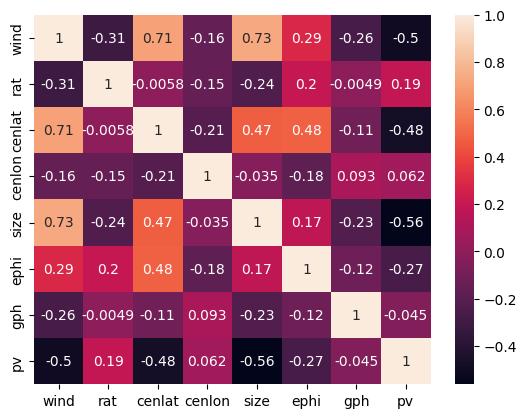

In [16]:
sns.heatmap(input.corr(), annot=True) ##heatmap for showing correlation across variables

### Start Random Forest Model. 

In [17]:
##first ... split data into training/testing ...
##this is just taking the first 58 years of data, leaving the remaining 5 for testing
X_train = input.iloc[:(58*137),:]
X_test = input.iloc[(58*137):,:]
Y_train = output[:(58*137)]
Y_test = output[(58*137):]

val_subset = (5*137) #index for subsetting validation data in cross val

In [18]:
X_train.describe()

,wind,rat,cenlat,cenlon,size,ephi,gph,pv
count,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000,7946.000000
mean,0.516949,0.511123,0.880152,0.660024,0.612196,0.626221,0.458038,0.265229
std,0.143197,0.091203,0.064689,0.145197,0.172868,0.243111,0.151007,0.122541
min,0.000000,0.330801,0.594425,0.000000,0.035200,0.000000,0.000000,0.000000
25%,0.420481,0.443107,0.845601,0.581625,0.489894,0.460031,0.352909,0.182527
50%,0.510507,0.497352,0.890945,0.686873,0.634398,0.702249,0.446063,0.251073
75%,0.614088,0.563221,0.926462,0.761662,0.744043,0.818349,0.552597,0.324281
max,1.000000,0.998701,0.994664,1.000000,1.000000,1.000000,1.000000,0.967684


In [42]:
#empty lists to save Accuracy
acc_reg1_val = []
acc_reg1_train = []
acc_reg1_test = []

##BSS Arrays, all of the skill scores have 200 rows
#because that is how many cross-validations I will do for the model
BSS_all= np.empty((100,2))
BSS_val= np.empty((100,2))
BSS_train= np.empty((100,2))
BSS_test= np.empty((100,2))

##RAS and PAS Arrays
Prec_all= np.empty((100,2))
Rec_all= np.empty((100,2))

Prec_val= np.empty((100,2))
Rec_val= np.empty((100,2))

Prec_train= np.empty((100,2))
Rec_train= np.empty((100,2))

Prec_test= np.empty((100,2))
Rec_test= np.empty((100,2))

important = np.empty((100,8))

In [43]:
#save PREDICTIONS
valP = []
testP = []
trainP = []

### Quick hyperparameter tuning intermission:

These cells are "raw" when they are not being used to avoid accidentally running them with my model. 

Okay... Now run it! 

In [44]:
#create initial regressor for rf to do feature selection 
rf_reg1 = RandomForestClassifier(max_depth=3, n_estimators=400, random_state=42)

In order for me to add in the appropriate skill scores, since this is a categorical classification, I had to create separate metrics with one hot encoding to calculate BSS/RAS/PAS ... Hence the addition of `utils.to_categorical` here.  

I also had to calculate the daily probability for each categorical classification, which is done in the temperature pre-processing file. 

In [45]:
import keras
Y_all = keras.utils.to_categorical(output)
Y_tes = keras.utils.to_categorical(Y_test)
X_all = input.values

In [46]:
##make loop for cross validation 
for l in range(0,100):
    print("Cross Val #:"+str(l))
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_train.iloc[:,0])-val_subset)
    end = start+(val_subset)

    #set distinct lists for climo based on testing/training
    climo_test = climo[(58*137):,:]
    climo_tr = climo[:(58*137),:]

    #create validation and training lists based on start/end date
    X_val = input.iloc[start:end,:]
    Y_val = output[start:end]
    climo_val = climo_tr[start:end,:]
    
    X_train1 = X_train.iloc[0:start]
    Y_train1 = Y_train[0:start]
    climo_train1 = climo_tr[0:start,:]
    X_train2 = X_train.iloc[end:]
    Y_train2 = Y_train[end:]
    climo_train2 = climo_tr[end:,:]

    ##concatenate all of these lists/arrays 
    X_tr = pd.concat([X_train1,X_train2], axis = 0)
    Y_tr = np.concatenate((Y_train1,Y_train2))
    climo_train = np.concatenate((climo_train1,climo_train2))

    #train rf model
    rf_reg1.fit(X_tr, Y_tr)

    pred1 = rf_reg1.predict(X_all) ##predictions based on all data, used for skill score calculations
    pred2 = rf_reg1.predict_proba(X_all) ##associated probabilities of all data
    
    #prediction with validation data
    pred_val1 = rf_reg1.predict(X_val)
    pred_val2 = rf_reg1.predict_proba(X_val)
    valP.append(pred_val1)
    acc_reg1_val.append(accuracy_score(Y_val, pred_val1))
    
    #prediction with training data
    pred_train1 = rf_reg1.predict(X_tr)
    pred_train2 = rf_reg1.predict_proba(X_tr)
    trainP.append(pred_train1)
    acc_reg1_train.append(accuracy_score(Y_tr, pred_train1))

    #prediction with testing data
    pred_test1 = rf_reg1.predict(X_test)
    pred_test2 = rf_reg1.predict_proba(X_test)
    testP.append(pred_test1)
    acc_reg1_test.append(accuracy_score(Y_test, pred_test1))
    ##############################################################
    #set lists for calculating PAS/RAS
    pred_class = []
    predval_class = []
    predtr_class = []
    predtest_class = []
    #one-hot encode specific validation and training datasets used here
    Y_tr2 = keras.utils.to_categorical(Y_tr)
    Y_val2 = keras.utils.to_categorical(Y_val)
    
    ##BRIER SKILL SCORE
    BSS(l, start, end,
        climo, pred2, Y_all, BSS_all,
        climo_val, pred_val2, Y_val2, BSS_val,
        climo_train, pred_train2, Y_tr2, BSS_train,
        climo_test, pred_test2, Y_tes, BSS_test)
    ##RECALL ACCURACY SCORE    
    RAS_two(l, Rec_all, climo, Y_all, pred2, pred_class,
            climo_val, Rec_val, Y_val2, pred_val2, predval_class,
            climo_train, Rec_train, Y_tr2, pred_train2, predtr_class,
            climo_test, Rec_test, Y_tes, pred_test2, predtest_class)
    ##PRECISION ACCURACY SCORE     
    PAS_two(l, Prec_all, climo, Y_all, pred2, pred_class,
            climo_val, Prec_val, Y_val2, pred_val2, predval_class,
            climo_train, Prec_train, Y_tr2, pred_train2, predtr_class,
            climo_test, Prec_test, Y_tes, pred_test2, predtest_class)

    #prepare to show relevant features by actually ... choosing them 
    selector = SelectFromModel(rf_reg1, threshold="mean", max_features=None)
    X_train_selected = selector.transform(X_tr)
    X_test_selected = selector.transform(X_test)

    #print names of selected features
    selected_features = input.columns[selector.get_support()]
    print(f'Selected Features: {selected_features}')

    importances = rf_reg1.feature_importances_
    important[l,:] = importances[:]

Cross Val #:0
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:1
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:2
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:3
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:4
Selected Features: Index(['wind', 'cenlon', 'size', 'pv'], dtype='object')
Cross Val #:5
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:6
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:7
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:8
Selected Features: Index(['wind', 'cenlon', 'size', 'pv'], dtype='object')
Cross Val #:9
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:10
Selected Features: Index(['wind', 'cenlon', 'size'], dtype='object')
Cross Val #:11
Selected Features: Index(['wind', 'cenlon', 'size'], dtype=

In [47]:
print('###################################################')
print(f'Accuracy, Validation: {np.mean(acc_reg1_val) * 100:.2f}%')
print(f'Accuracy, Training: {np.mean(acc_reg1_train) * 100:.2f}%')
print(f'Accuracy, Testing: {np.mean(acc_reg1_test) * 100:.2f}%')

###################################################
Accuracy, Validation: 60.77%
Accuracy, Training: 63.05%
Accuracy, Testing: 61.54%


Now create plot of Skill Scores relevant to this model. 

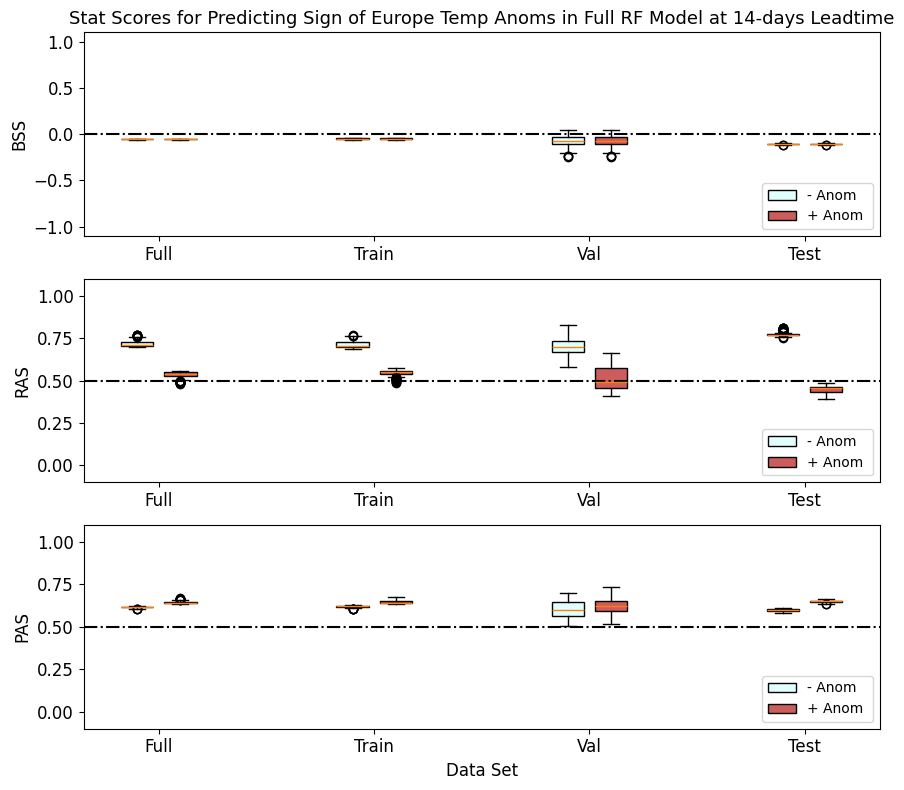

In [60]:
#plot
fig = plt.figure(figsize=(9,8))
font = 12
#loop through each member
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

ticks = ['Full', 'Train', 'Val', 'Test'] #set tick numbers for dataset
colors = ['lightcyan','indianred']
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.3 #box-plot width
labels = ['- Anom', '+ Anom '] #labels of quantiles


##begin to go plot by plot ...
#each plot has a separate plot function for each lead time. In these, the plots get each quantile plotted. 
ax1.set_title("Stat Scores for Predicting Sign of Europe Temp Anoms in Full RF Model at 14-days Leadtime",fontsize = 13) 

a1_0 = ax1.boxplot([BSS_all[:,0],BSS_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a1_5 = ax1.boxplot([BSS_train[:,0],BSS_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a1_10 = ax1.boxplot([BSS_val[:,0],BSS_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a1_14 = ax1.boxplot([BSS_test[:,0],BSS_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax1.axhline(0, c='k', ls ='-.')
ax1.set_xticks(ind, ticks)
#next few lines color the box plot faces
for bplot in (a1_0, a1_5, a1_10, a1_14,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a1_0['boxes'], labels):
    patch.set_label(label)
#ax1.set_title('BSS for Temperature Region',fontsize = 14)
ax1.set_ylim(-1.1,1.1)
#ax1.set_xlabel('Data Set',fontsize = 14)
ax1.set_ylabel('BSS',fontsize = font)
ax1.tick_params(axis='both', which='major', labelsize= font)
ax1.legend(loc = 'lower right', fontsize = 10)
ax1.set_aspect('auto') ;

##repeat the process
a2_0 = ax2.boxplot([Rec_all[:,0],Rec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a2_5 = ax2.boxplot([Rec_train[:,0],Rec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a2_10 = ax2.boxplot([Rec_val[:,0],Rec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a2_14 = ax2.boxplot([Rec_test[:,0],Rec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax2.axhline(0.5, c='k', ls ='-.')
ax2.set_xticks(ind, ticks)
for bplot in (a2_0, a2_5, a2_10, a2_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a2_0['boxes'], labels):
    patch.set_label(label)
#ax2.set_title('RAS for Temperature Region',fontsize = 14)
ax2.set_ylim(-0.1,1.1)
ax2.tick_params(axis='both', which='major', labelsize= font)
ax2.set_ylabel('RAS',fontsize = font)
#ax2.set_xlabel('Data Set',fontsize = 14)
#ax2.set_ylabel('Brier Skill Score')
ax2.legend(loc = 'lower right', fontsize = 10)
ax2.set_aspect('auto') ;

a3_0 = ax3.boxplot([Prec_all[:,0],Prec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a3_5 = ax3.boxplot([Prec_train[:,0],Prec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a3_10 = ax3.boxplot([Prec_val[:,0],Prec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a3_14 = ax3.boxplot([Prec_test[:,0],Prec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax3.axhline(0.5, c='k', ls ='-.')
ax3.set_xticks(ind, ticks)
for bplot in (a3_0, a3_5, a3_10, a3_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a3_0['boxes'], labels):
    patch.set_label(label)
#ax3.set_title('RAS Well')
#ax3.set_title('PAS for Temperature Region',fontsize = 14)
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel('PAS',fontsize = font)
ax3.set_xlabel('Data Set',fontsize = font)
#ax3.set_ylabel('Recall Accuracy Score',fontsize = 14)
ax3.tick_params(axis='both', which='major', labelsize= font)
ax3.legend(loc = 'lower right', fontsize = 10)
ax3.set_aspect('auto') ;

plt.tight_layout()
#plt.show()
plt.savefig("FullRF_14days_StatScore.png", bbox_inches='tight',dpi =150)


In [61]:
#take average across all feature importance values by cross validation
imp = np.nanmean(important, axis = 0)
imp.shape

(8,)

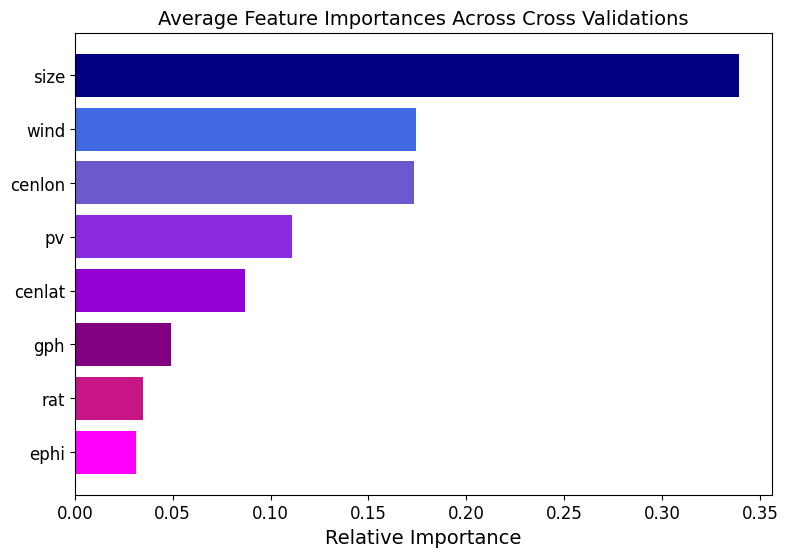

In [63]:
#plot features by relative importance
indices = np.argsort(imp)[::-1]  #sort by importance
c = ["navy","royalblue","slateblue","blueviolet","darkviolet","purple","mediumvioletred","magenta"]

plt.figure(figsize=(9, 6))
plt.title("Average Feature Importances Across Cross Validations",fontsize =14)
plt.barh(range(input.shape[1]), imp[indices], align="center", color = c)
plt.yticks(range(input.shape[1]), input.columns[indices],fontsize =12)
plt.xticks(fontsize =12)
plt.xlabel("Relative Importance",fontsize =14)
plt.gca().invert_yaxis()
plt.savefig("RF_FeatureImportance_14days.png")

### Begin Second Model. 

In [74]:
##change pandas dataframe to choose top 3 important features only
input2 = input[['size', "wind", "cenlon"]]
#input2 = input

In [75]:
#AGAIN, empty lists 
#empty lists to save Accuracy
acc_reg2_val = []
acc_reg2_train = []
acc_reg2_test = []

##BSS Arrays
BSS_all= np.empty((100,2))
BSS_val= np.empty((100,2))
BSS_train= np.empty((100,2))
BSS_test= np.empty((100,2))

##RAS and PAS Arrays
Prec_all= np.empty((100,2))
Rec_all= np.empty((100,2))

Prec_val= np.empty((100,2))
Rec_val= np.empty((100,2))

Prec_train= np.empty((100,2))
Rec_train= np.empty((100,2))

Prec_test= np.empty((100,2))
Rec_test= np.empty((100,2))

#save PREDICTIONS
test90_acc = []
##full model
fulltest_acc = []

##correct positive
posXtest = []
#false positive
FposXtest = []
#correct negative
negXtest = []
#false negative
FnegXtest = []

indexes = []


##correct positive
percpos = []
#false positive
percFpos = []
#correct negative
percneg = []
#false negative
percFneg = []

In [76]:
##split data into training/testing ...
##this is just taking the first 58 years of data, leaving the remaining 5 for testing
X_train = input2.iloc[:(58*137),:]
X_test = input2.iloc[(58*137):,:]
Y_train = output[:(58*137)]
Y_test = output[(58*137):]

val_subset = (5*137) #index for subsetting validation data in cross val

In [77]:
##definition statement for looking further into the 10% most confident predictions
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [78]:
#as before, one-hot encode datasets. 
Y_all = keras.utils.to_categorical(output)
Y_tes = keras.utils.to_categorical(Y_test)
X_all = input2.values

In [79]:
#second random forest model with selected features only
rf_reg2 = RandomForestClassifier(max_depth=3, n_estimators=400, random_state=42)

In [80]:
##make loop for cross validation 
##process is mainly the same as previous loop but there is an added section to select/evaluate the 10% most confident and correct predictions
for l in range(0,100):
    print("Cross Val #:"+str(l))
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_train.iloc[:,0])-val_subset)
    end = start+(val_subset)

    climo_test = climo[(58*137):,:]
    climo_tr = climo[:(58*137),:]
    
    X_val = input2.iloc[start:end,:]
    Y_val = output[start:end]
    climo_val = climo_tr[start:end,:]
    
    X_train1 = X_train.iloc[0:start]
    Y_train1 = Y_train[0:start]
    X_train2 = X_train.iloc[end:]
    Y_train2 = Y_train[end:]
    climo_train1 = climo_tr[0:start,:]
    climo_train2 = climo_tr[end:,:]

    ##concatenate all of these
    X_tr = pd.concat([X_train1,X_train2], axis = 0)
    Y_tr = np.concatenate((Y_train1,Y_train2))
    climo_train = np.concatenate((climo_train1,climo_train2))

    #train rf
    rf_reg2.fit(X_tr, Y_tr)
    pred1 = rf_reg2.predict(X_all)
    pred2 = rf_reg2.predict_proba(X_all)
    
    #prediction with validation data
    pred_val1 = rf_reg2.predict(X_val)
    pred_val2 = rf_reg2.predict_proba(X_val)
    valP.append(pred_val1)
    acc_reg2_val.append(accuracy_score(Y_val, pred_val1))
    
    #prediction with training data
    pred_train1 = rf_reg2.predict(X_tr)
    pred_train2 = rf_reg2.predict_proba(X_tr)
    trainP.append(pred_train1)
    acc_reg2_train.append(accuracy_score(Y_tr, pred_train1))

    #prediction with testing data
    pred_test1 = rf_reg2.predict(X_test)
    pred_test2 = rf_reg2.predict_proba(X_test)
    testP.append(pred_test1)
    acc_reg2_test.append(accuracy_score(Y_test, pred_test1))
    ##############################################################
    pred_class = []
    predval_class = []
    predtr_class = []
    predtest_class = []

    Y_tr2 = keras.utils.to_categorical(Y_tr)
    Y_val2 = keras.utils.to_categorical(Y_val)
    
    ##BRIER SKILL SCORE
    BSS(l, start, end,
        climo, pred2, Y_all, BSS_all,
        climo_val, pred_val2, Y_val2, BSS_val,
        climo_train, pred_train2, Y_tr2, BSS_train,
        climo_test, pred_test2, Y_tes, BSS_test)
    ##RECALL ACCURACY SCORE    
    RAS_two(l, Rec_all, climo, Y_all, pred2, pred_class,
            climo_val, Rec_val, Y_val2, pred_val2, predval_class,
            climo_train, Rec_train, Y_tr2, pred_train2, predtr_class,
            climo_test, Rec_test, Y_tes, pred_test2, predtest_class)
    ##PRECISION ACCURACY SCORE     
    PAS_two(l, Prec_all, climo, Y_all, pred2, pred_class,
            climo_val, Prec_val, Y_val2, pred_val2, predval_class,
            climo_train, Prec_train, Y_tr2, pred_train2, predtr_class,
            climo_test, Prec_test, Y_tes, pred_test2, predtest_class)

    ####################################################################
    ##EVALUATE MOST CONFIDENT PREDICTIONS
    q90 = np.percentile(pred_test2,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_test2) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test90 = pred_test2[great90]
    test90_norm = Y_tes[great90]
    test90_acc.append(calculate_accuracy(test90_norm, test90, threshold=0.5)) ##calculate distribution of accuracy for 90th percentile predictions
    ##full model
    fulltest_acc.append(calculate_accuracy(Y_tes, pred_test2, threshold=0.5)) ##calculate accuracy of all predictions

    ##classify the accuracy of predicitons
    correct_pos = [] #correct positive anomaly
    correct_neg = [] #correct negative anomaly
    
    false_pos = [] #false positive
    false_neg = [] #false negative

    indexes.extend(great90)
    for j in range(len(great90)):
        #print(j)
        #print(great90[j])
        index = great90[j]
        if pred_test2[index,0] < pred_test2[index,1] and Y_tes[index,0] == 0: ##correct prediction of positive outcome
            correct_pos.append(index)
            #print('###########')
        elif pred_test2[index,0] > pred_test2[index,1] and Y_tes[index,0] == 1: ##correct prediction of negative outcome
            correct_neg.append(index)
            #print('###########')
        elif pred_test2[index,0] < pred_test2[index,1] and Y_tes[index,0] == 1: ##incorrect prediction of negative outcome
            false_neg.append(index)
            #print('###########')
        elif pred_test2[index,0] > pred_test2[index,1] and Y_tes[index,0] == 0: ##correct prediction of positive outcome
            false_pos.append(index)
            #print('###########')

    ##correct positive
    posXtest.extend(correct_pos)
    #false positive
    FposXtest.extend(false_pos)
    #correct negative
    negXtest.extend(correct_neg)
    #false negative
    FnegXtest.extend(false_neg)
    
    percpos.append(len(correct_pos)/len(great90))
    #false positive
    percFpos.append(len(false_pos)/len(great90))
    #correct negative
    percneg.append(len(correct_neg)/len(great90))
    #false negative
    percFneg.append(len(false_neg)/len(great90))

Cross Val #:0
Cross Val #:1
Cross Val #:2
Cross Val #:3
Cross Val #:4
Cross Val #:5
Cross Val #:6
Cross Val #:7
Cross Val #:8
Cross Val #:9
Cross Val #:10
Cross Val #:11
Cross Val #:12
Cross Val #:13
Cross Val #:14
Cross Val #:15
Cross Val #:16
Cross Val #:17
Cross Val #:18
Cross Val #:19
Cross Val #:20
Cross Val #:21
Cross Val #:22
Cross Val #:23
Cross Val #:24
Cross Val #:25
Cross Val #:26
Cross Val #:27
Cross Val #:28
Cross Val #:29
Cross Val #:30
Cross Val #:31
Cross Val #:32
Cross Val #:33
Cross Val #:34
Cross Val #:35
Cross Val #:36
Cross Val #:37
Cross Val #:38
Cross Val #:39
Cross Val #:40
Cross Val #:41
Cross Val #:42
Cross Val #:43
Cross Val #:44
Cross Val #:45
Cross Val #:46
Cross Val #:47
Cross Val #:48
Cross Val #:49
Cross Val #:50
Cross Val #:51
Cross Val #:52
Cross Val #:53
Cross Val #:54
Cross Val #:55
Cross Val #:56
Cross Val #:57
Cross Val #:58
Cross Val #:59
Cross Val #:60
Cross Val #:61
Cross Val #:62
Cross Val #:63
Cross Val #:64
Cross Val #:65
Cross Val #:66
Cross

In [81]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable


In [82]:
print('###################################################')
print(f'Accuracy, Validation: {np.mean(acc_reg2_val) * 100:.2f}%')
print(f'Accuracy, Training: {np.mean(acc_reg2_train) * 100:.2f}%')
print(f'Accuracy, Testing: {np.mean(acc_reg2_test) * 100:.2f}%')

###################################################
Accuracy, Validation: 61.55%
Accuracy, Training: 62.96%
Accuracy, Testing: 61.10%


Same as before, plot Skill Scores. 

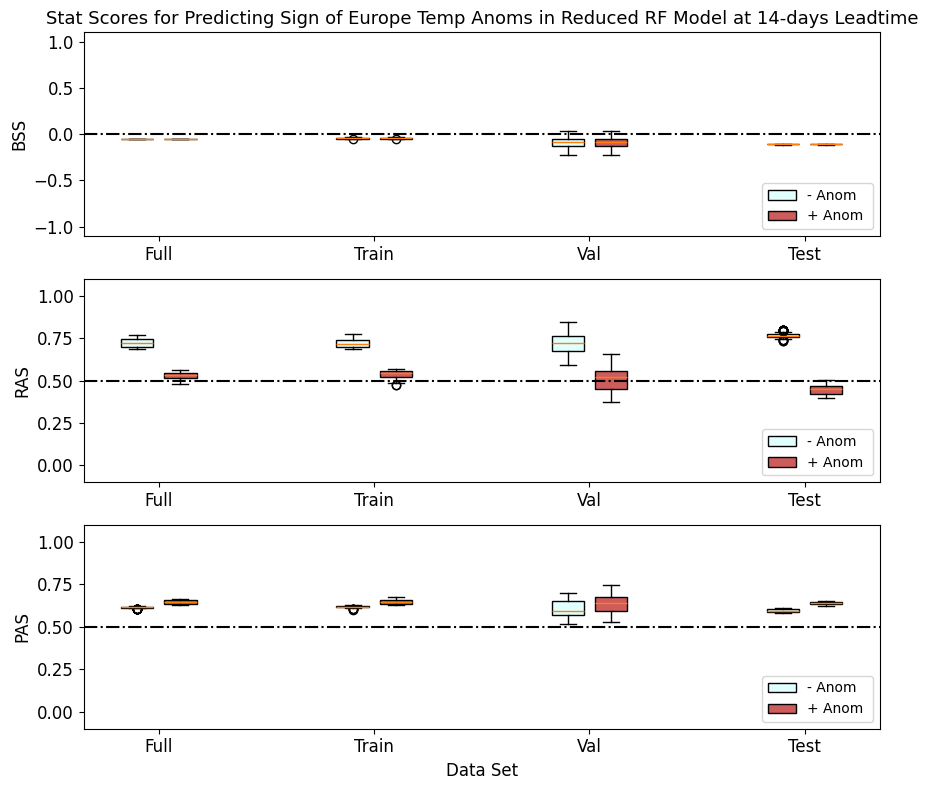

In [83]:
#plot
fig = plt.figure(figsize=(9,8))
font = 12
#loop through each member
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

ticks = ['Full', 'Train', 'Val', 'Test'] #set tick numbers for dataset
colors = ['lightcyan','indianred']
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.3 #box-plot width
labels = ['- Anom', '+ Anom '] #labels of quantiles


##begin to go plot by plot ...
#each plot has a separate plot function for each lead time. In these, the plots get each quantile plotted. 
ax1.set_title("Stat Scores for Predicting Sign of Europe Temp Anoms in Reduced RF Model at 14-days Leadtime",fontsize = 13) 

a1_0 = ax1.boxplot([BSS_all[:,0],BSS_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a1_5 = ax1.boxplot([BSS_train[:,0],BSS_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a1_10 = ax1.boxplot([BSS_val[:,0],BSS_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a1_14 = ax1.boxplot([BSS_test[:,0],BSS_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax1.axhline(0, c='k', ls ='-.')
ax1.set_xticks(ind, ticks)
#next few lines color the box plot faces
for bplot in (a1_0, a1_5, a1_10, a1_14,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a1_0['boxes'], labels):
    patch.set_label(label)
#ax1.set_title('BSS for Temperature Region',fontsize = 14)
ax1.set_ylim(-1.1,1.1)
#ax1.set_xlabel('Data Set',fontsize = 14)
ax1.set_ylabel('BSS',fontsize = font)
ax1.tick_params(axis='both', which='major', labelsize= font)
ax1.legend(loc = 'lower right', fontsize = 10)
ax1.set_aspect('auto') ;

##repeat the process
a2_0 = ax2.boxplot([Rec_all[:,0],Rec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a2_5 = ax2.boxplot([Rec_train[:,0],Rec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a2_10 = ax2.boxplot([Rec_val[:,0],Rec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a2_14 = ax2.boxplot([Rec_test[:,0],Rec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax2.axhline(0.5, c='k', ls ='-.')
ax2.set_xticks(ind, ticks)
for bplot in (a2_0, a2_5, a2_10, a2_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a2_0['boxes'], labels):
    patch.set_label(label)
#ax2.set_title('RAS for Temperature Region',fontsize = 14)
ax2.set_ylim(-0.1,1.1)
ax2.tick_params(axis='both', which='major', labelsize= font)
ax2.set_ylabel('RAS',fontsize = font)
#ax2.set_xlabel('Data Set',fontsize = 14)
#ax2.set_ylabel('Brier Skill Score')
ax2.legend(loc = 'lower right', fontsize = 10)
ax2.set_aspect('auto') ;

a3_0 = ax3.boxplot([Prec_all[:,0],Prec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a3_5 = ax3.boxplot([Prec_train[:,0],Prec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a3_10 = ax3.boxplot([Prec_val[:,0],Prec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a3_14 = ax3.boxplot([Prec_test[:,0],Prec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax3.axhline(0.5, c='k', ls ='-.')
ax3.set_xticks(ind, ticks)
for bplot in (a3_0, a3_5, a3_10, a3_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a3_0['boxes'], labels):
    patch.set_label(label)
#ax3.set_title('RAS Well')
#ax3.set_title('PAS for Temperature Region',fontsize = 14)
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel('PAS',fontsize = font)
ax3.set_xlabel('Data Set',fontsize = font)
#ax3.set_ylabel('Recall Accuracy Score',fontsize = 14)
ax3.tick_params(axis='both', which='major', labelsize= font)
ax3.legend(loc = 'lower right', fontsize = 10)
ax3.set_aspect('auto') ;

plt.tight_layout()
#plt.show()
plt.savefig("RedRF_14days_StatScore.png", bbox_inches='tight',dpi =150)


In [84]:
#try SHAP with the second RF model to see if the ranking of features compares/whether the signs of features are physically consistent
import shap

explainer = shap.TreeExplainer(rf_reg2)

In [85]:
shap_values = explainer.shap_values(X_test)
shap_obj = explainer(X_test)

In [86]:
shap_obj.shape

(685, 3, 2)

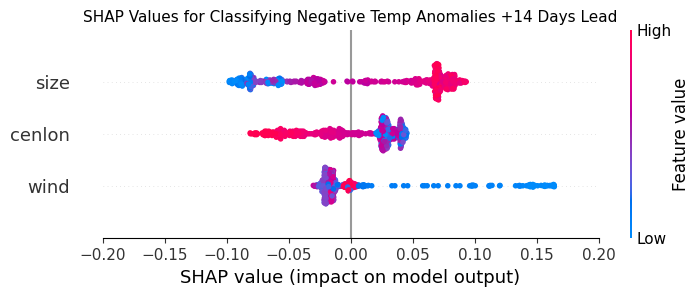

In [95]:
plt.title("SHAP Values for Classifying Negative Temp Anomalies +14 Days Lead",fontsize =11)
ax = shap.plots.beeswarm(shap_obj[:,:,0], show = False) ##for negative classifications ... this is physically consistent!
ax.set_xlim(-0.2,0.2)

plt.savefig("RFshap_Neg_Pred_14days.png")

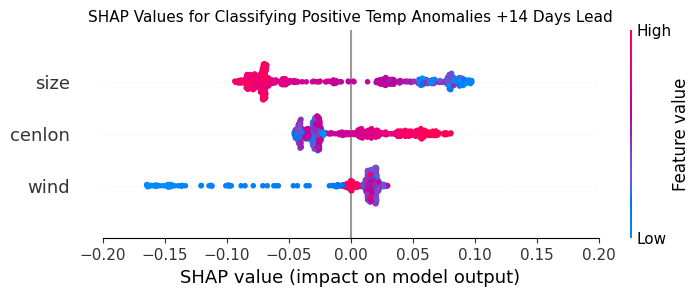

In [96]:
plt.title("SHAP Values for Classifying Positive Temp Anomalies +14 Days Lead",fontsize =11)
ax = shap.plots.beeswarm(shap_obj[:,:,1], show = False) ##for positive classifications ... this is physically consistent!
ax.set_xlim(-0.2,0.2)
plt.savefig("RFshap_Pos_Pred_14days.png")

Text(0.5, 1.0, 'Testing Prediction Accuracy Across 100 RF Models')

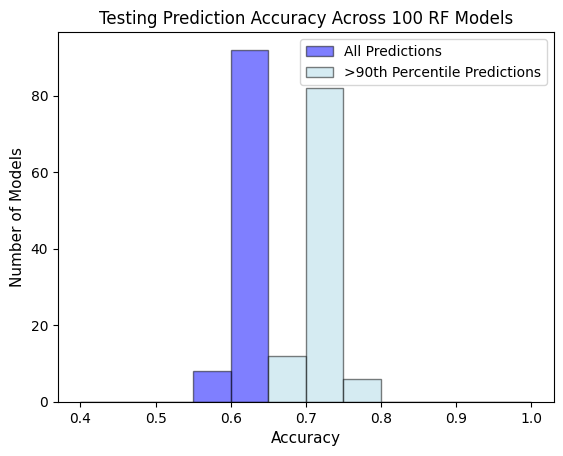

In [89]:
#######bar plot for showing the distribution of confident predictions
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(test90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltest_acc, bins=bins)
#plot the full dataset
#offset = 0.02  #adjust this value if needed to see bars more easily
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
#plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy',fontsize =11)
plt.ylabel('Number of Models',fontsize =11)
plt.legend()
plt.title('Testing Prediction Accuracy Across 100 RF Models',fontsize =12)

In [90]:
##Check % of incorrect vs. correct predictions at the higher confidence level
##correct positive
posXtest = np.array(posXtest)
#false positive
FposXtest = np.array(FposXtest)
#correct negative
negXtest = np.array(negXtest)
#false negative
FnegXtest = np.array(FnegXtest)

indexes = np.array(indexes)

In [91]:
print(f'Average Num. of 10% Confident and Correct Postive Predictions: {np.mean(percpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and Correct Negative Predictions: {np.mean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Postive Predictions: {np.mean(percFpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Negative Predictions: {np.mean(percFneg)* 100:.2f}%')
print('#######################################################################')
print(f'Average Num. of 10% Confident and Correct Predictions: {np.mean(percpos)* 100 + np.mean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Predictions: {np.mean(percFpos)* 100 +np.mean(percFneg)* 100:.2f}%')

Average Num. of 10% Confident and Correct Postive Predictions: 31.61%
Average Num. of 10% Confident and Correct Negative Predictions: 40.27%
Average Num. of 10% Confident and FALSE Postive Predictions: 9.72%
Average Num. of 10% Confident and FALSE Negative Predictions: 18.39%
#######################################################################
Average Num. of 10% Confident and Correct Predictions: 71.89%
Average Num. of 10% Confident and FALSE Predictions: 28.11%


In [92]:
####now I wanna make these plots SO ... I am adding an index column on to X_test ... full version. 
#This will be exported out to be plotted in RF_Pred_Plot.
X_test = input.iloc[(58*141):,:]
ranges = np.array([x for x in range(0,705,1)])
ranges = ranges.reshape(5,141) 
ranges.shape

(5, 141)

In [93]:
ranges[0,0:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [94]:
##export out files to make the next few plots w/o normalization
pickle.dump(ranges, open("range_indices_RF14.p", 'wb'))
pickle.dump(posXtest, open("posXtest_RF14.p", 'wb'))
pickle.dump(FposXtest, open("FposXtest_RF14.p", 'wb'))
pickle.dump(negXtest, open("negXtest_RF14.p", 'wb'))
pickle.dump(FnegXtest, open("FnegXtest_RF14.p", 'wb'))